# Analisi California Housing

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 2. Caricamento dataset
data = fetch_california_housing(as_frame=True)
df = data.frame 

# 3. Separazione feature e target
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

In [ ]:
# 4. Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# 5. Divisione train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
# 6. Creazione e addestramento modello XGBoost Regressor
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
# 7. Predizione
y_pred = model.predict(X_test)

In [12]:
# 8. Valutazione del modello
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [13]:
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error (MSE): 0.56
R^2 Score: 0.58


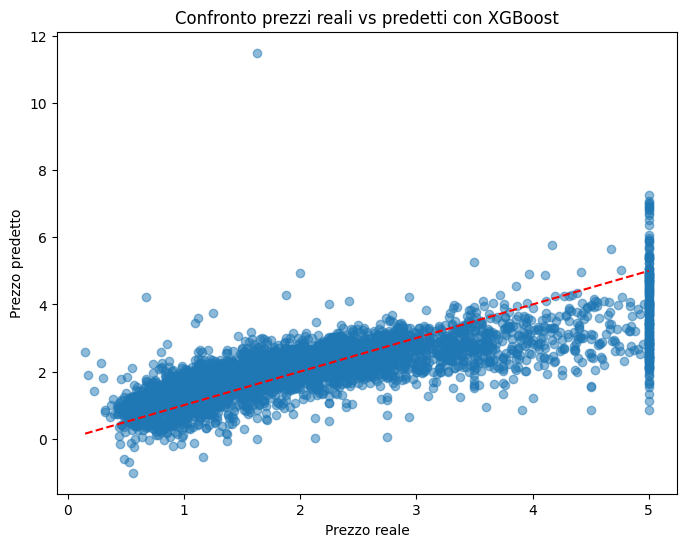

In [14]:
# 9. Grafico confronto valori reali vs predetti
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prezzo reale")
plt.ylabel("Prezzo predetto")
plt.title("Confronto prezzi reali vs predetti con XGBoost")
plt.show()